In [1]:
import tensorflow as tf
import sys
import os
from time import time
import pandas as pd
import numpy as np
import mlutils
%matplotlib inline

/opt/miniconda/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from tensorflow.python.keras.preprocessing.image  import ImageDataGenerator, array_to_img, img_to_array, load_img  #Para preprocesar las iamgenes que le vamos a dar para entrenar nuestro algoritmo
from tensorflow.python.keras import optimizers   # esto funciona con esta linea y luego llamando como .tf import tensorflow as tf layers = tf.keras.layers.Flatten()(layers)
from tensorflow.python.keras.models  import Sequential  #Librería para hacer las redes neuronales secuenciales
from tensorflow.python.keras.layers import  Dropout, Flatten, Dense, Activation
from tensorflow.python.keras.layers import  Convolution2D, MaxPooling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import applications

from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model

Using TensorFlow backend.


In [3]:
K.clear_session()

In [4]:
#Directorio de donde tenemos nuestras imagenes para entrenar y validar
data_entrenamiento= './data/entrenamiento'
data_validacion= './data/validacion'

In [20]:
epocas=5  #numero de interaciones que haremos
altura, longitud= 100,100 #Tamaño al cual vamos a procesar nuestras imagenes en pixeles
batch_size=6 #numero de imagenes que le vamos a enviar a nuestra computadora a procesar en cada uno de los pasos
pasos=100 #numero de veces que se procesará la información en cada una de las épocas c/epoca=1000pasos
pasos_validacion=200 #Al finalizar cada época se van a correr 200 pasos con el set de validacion para validar qué tal va el aprendizaje
filtrosConv1=32 # neustra imagen tendrá prfundidad de 32
filtrosConv2=64 #numero de filtros que aplicaremos en cada conv., nuestra img. tendrá profundidad de 64
tamano_filtro1= (3,3) #Altura y longitud de 3
tamano_filtro2=(2,2)
tamano_pool=(2,2)  #tamaño del filtro que tuilizaremos en el maxpooling
clases=2 # 3 vlores de angulo azimutal(0,300,350)
lr=0.0005 #learningrate Qué tan grande serán los ajustes que hace la red para acercarse a la opcion optima


In [ ]:
#Para poder empezar el entrenamiento debemos tener las imagenes preprocesadas

entrenamiento_datagen=ImageDataGenerator(
    rescale=1./255,  #cada pixel están de 0 a 1 para hacer más eficiente el entrenamiento en vez de ir de 0-255
) # generador


validacion_datagen=ImageDataGenerator(
    rescale=1./255,  #cada pixel están de 0 a 1 para hacer más eficiente el entrenamiento en vez de ir de 0-255
) # generador

In [22]:
imagen_entrenamiento= lambda: entrenamiento_datagen.flow_from_directory(
    data_entrenamiento,
    target_size=(altura, longitud),
    batch_size=batch_size,
    class_mode='binary' #La clasificación será categórica
    # Entra a neustro directorio a dataentrenamiento y abrirá todas las carpeta y procesará según losingresado
)


In [23]:
imagen_validacion=lambda: validacion_datagen.flow_from_directory(
    data_validacion,
    target_size=(altura, longitud),
    batch_size=batch_size,
    class_mode='binary' #La clasificación será categórica
    # Entra a neustro directorio a dataentrenamiento y abrirá todas las carpeta y procesará según losingresado
)


Found 6 images belonging to 3 classes.


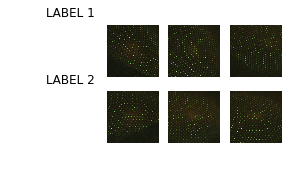

In [24]:
for imgs,labels in imagen_entrenamiento ():
    if np.random.random()>.5:
        break
reload(mlutils)        
mlutils.show_labeled_image_mosaic(imgs, labels)

In [ ]:
#crear la CNN

cnn = Sequential()
cnn.add(Convolution2D(filtrosConv1, tamano_filtro1, padding ="same", input_shape=(longitud, altura, 3), activation='relu')) #Primera capa
cnn.add(MaxPooling2D(pool_size=tamano_pool)) #después de la 1era capa de convolucion tendremos una capa de maxpooling de2,2pix.

cnn.add(Convolution2D(filtrosConv2, tamano_filtro2, padding ="same"))
cnn.add(MaxPooling2D(pool_size=tamano_pool))

cnn.add(Flatten()) #empezar nuestra clasificación, esa imagen que ahora es muy profunda pero epequeña, la haremos plana
cnn.add(Dense(256, activation='relu')) #256 neuronas, después de aplanar la info, le enviamos esa info. a una capa normal
cnn.add(Dropout(0.5))  #le apagaremos el 50% aleatoriamente de la neuronas cada paso, para evitar sobreajustar. Aprenderá caminos diferentes
cnn.add(Dense(3, activation='softmax')) #última capa 3 neuronas, nsoftmaz nos ayudará a decir el porcentaje de la aparición de la imagen
    

In [29]:
cnn.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=lr), metrics=['accuracy']) #Parametrs que vamos a usar para optimizar nuestro algo, fn loss categoría cross.

In [30]:
cnn.fit_generator(imagen_entrenamiento (),
        steps_per_epoch=pasos,
        epochs=epocas,
        validation_data= imagen_validacion(),
        validation_steps=200
       )

Found 6 images belonging to 3 classes.
Found 6 images belonging to 3 classes.
Epoch 1/5
100/100 [==============================] - 91s 914ms/step - loss: 0.0648 - acc: 0.9717 - val_loss: 4.2000e-05 - val_acc: 1.0000
Epoch 2/5
100/100 [==============================] - 85s 846ms/step - loss: 1.1862e-04 - acc: 1.0000 - val_loss: 1.1325e-05 - val_acc: 1.0000
Epoch 3/5
100/100 [==============================] - 90s 897ms/step - loss: 8.5423e-05 - acc: 1.0000 - val_loss: 4.5895e-06 - val_acc: 1.0000
Epoch 4/5
100/100 [==============================] - 92s 921ms/step - loss: 4.1446e-05 - acc: 1.0000 - val_loss: 2.6226e-06 - val_acc: 1.0000
Epoch 5/5
100/100 [==============================] - 92s 915ms/step - loss: 4.4733e-05 - acc: 1.0000 - val_loss: 1.4702e-06 - val_acc: 1.0000


In [129]:
target_dir = './modelo/'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
cnn.save('./modelo/modelo.h5')
cnn.save_weights('./modelo/pesos.h5')

In [ ]:
longitud, altura = 100, 100
modelo = './modelo/modelo.h5'
pesos_modelo = './modelo/pesos.h5'
cnn = load_model(modelo)
cnn.load_weights(pesos_modelo)

def predict(file):
  x = load_img(file, target_size=(longitud, altura))
  x = img_to_array(x)
  x = np.expand_dims(x, axis=0)
  array = cnn.predict(x)
  result = array[0]
  answer = np.argmax(result)
  if answer == 0:
    print("No hay nada ")
  elif answer == 1:
    print("pred: azimutal300")
  elif answer == 2:
    print("pred: azimutal350")


    return answer

In [131]:
predict ('Frame106_Elevation20_Azimuth300.tif')

pred: azimutal300


In [132]:
predict ('Frame103_Elevation50_Azimuth300.tif')

pred: azimutal300


In [133]:
predict ('Frame023_Elevation10_Azimuth350.tif')

pred: azimutal350


2

In [162]:
def show_preds(x, preds):
    for i  in np.random.permutation(range(len(preds)))[:4]:
        plt.figure(figsize=(8,9))
        plt.subplot(122)
        plt.imshow(x[i])
        plt.axis("off")
        plt.subplot(121)
        plt.bar(np.arange(2), preds[i], color="blue", alpha=.5, label="prediction")
        plt.bar(np.arange(2), np.eye(2,2)[int(y[i])], color="red", alpha=.5, label="label")
        plt.xticks(range(2), range(2), rotation="vertical");
        plt.xlim(-.5,1.5);
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, +1.35),ncol=5)

Found 6 images belonging to 3 classes.


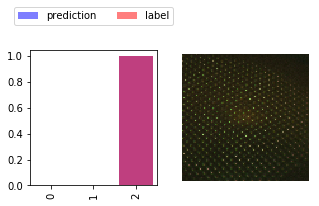

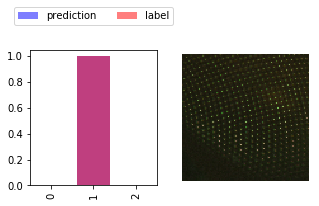

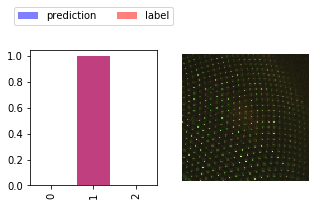

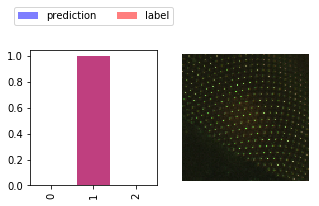

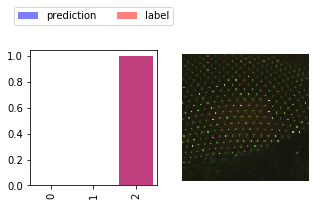

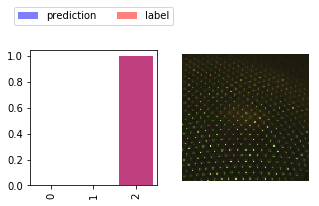

In [163]:
for x,y in imagen_validacion():
    if np.random.random()>.7:
        break
preds = cnn.predict(x)     
mlutils.show_preds(x, y, preds)